# Проект "Отток клиентов".

Из «Омега-Банка» каждый месяц стали уходить клиенты. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. На основании имеющихся данных о поведении клиентов и расторжении договоров с банком попробуем спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

## Содержание.  <a class="anchor" id="0-bullet">
* [1. Подготовка данных](#1-bullet)
    * [1.1. Получение данных](#1.1-bullet)
    * [1.2. Предобработка данных](#1.2-bullet)
* [2. Исследование задачи](#2-bullet)
    * [2.1. Разбиение данных](#2.1-bullet)
    * [2.2. Исследование моделей](#2.2-bullet)
        * [2.2.1. Дерево решений](#2.2.1-bullet)
        * [2.2.2. Случайный лес](#2.2.2-bullet)
        * [2.2.3. Логистическая регрессия](#2.2.3-bullet)
* [3. Борьба с дисбалансом](#3-bullet)
    * [3.1. Увеличение выборки](#3.1-bullet)
        * [3.1.1. Дерево решений](#3.1.1-bullet)
        * [3.1.2. Случайный лес](#3.1.2-bullet)
        * [3.1.3. Логистическая регрессия](#3.1.3-bullet)
    * [3.2. Уменьшение выборки](#3.2-bullet)
        * [3.2.1. Дерево решений](#3.2.1-bullet)
        * [3.2.2. Случайный лес](#3.2.2-bullet)
        * [3.2.3. Логистическая регрессия](#3.2.3-bullet)
* [4. Тестирование модели](#4-bullet)

# 1. Подготовка данных<a class="anchor" id="1-bullet"></a>

## 1.1. Получение данных<a class="anchor" id="1.1-bullet"></a>

<span style="color:purple">Вызовем необходимые библиотеки, откроем файл данных и изучим обшую информацию.<span>

In [26]:
# импортируем библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

# считаем файл данных
data = pd.read_csv('/datasets/Churn.csv')

In [27]:
# выведем информацию для загруженной таблицы
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

In [28]:
# поближе познакомимся с данными
display(pd.concat([data.head(3), data.tail(2)]))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


<span style="color:purple">В датасете присутствует 10000 записей. Аналитика представлена 14 позициями:<span>
    
<span style="color:purple">Признаки:<span>
    
<span style="color:purple">RowNumber — индекс строки в данных<span>
    
<span style="color:purple">CustomerId — уникальный идентификатор клиента<span>
    
<span style="color:purple">Surname — фамилия<span>
    
<span style="color:purple">CreditScore — кредитный рейтинг<span>
    
<span style="color:purple">Geography — страна проживания<span>
    
<span style="color:purple">Gender — пол<span>
    
<span style="color:purple">Age — возраст<span>
    
<span style="color:purple">Tenure — количество недвижимости у клиента<span>
    
<span style="color:purple">Balance — баланс на счёте<span>
    
<span style="color:purple">NumOfProducts — количество продуктов банка, используемых клиентом<span>
    
<span style="color:purple">HasCrCard — наличие кредитной карты<span>
    
<span style="color:purple">IsActiveMember — активность клиента<span>
    
<span style="color:purple">EstimatedSalary — предполагаемая зарплата<span>
        
<span style="color:purple">Целевой признак:<span>
    
<span style="color:purple">Exited — факт ухода клиента<span>

## 1.2. Предобрабока данных<a class="anchor" id="1.2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">В столбце Tenure присутствуют пропуски. Заполним их медианным значением. Кроме того, удалим не представляющие интереса для анализа столбцы RowNumber, CustomerId и Surname.<span>

In [29]:
# заполним пропуски
data.loc[data['Tenure'].isna(), 'Tenure'] = data['Tenure'].median()

# удалим ненужные столбцы
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# посмотрим, что получилось
display(pd.concat([data.head(3), data.tail(2)]))
display(data.info())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,5.0,130142.79,1,1,0,38190.78,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


None

<span style="color:purple">Данные готовы для исследовательской работы.<span>

# 2. Исследование задачи<a class="anchor" id="2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

## 2.1. Разбиение данных<a class="anchor" id="2.1-bullet"></a>

<span style="color:purple">Разделим данные на признаки и целевое значение.<span>

In [30]:
features = data.drop('Exited', axis=1)
target = data['Exited']

<span style="color:purple">Среди признаков есть два категориальных - Geography и Gender. Обработаем их техникой OHE.<span>

In [31]:
features = pd.get_dummies(features, columns=['Geography', 'Gender'], drop_first=True)

<span style="color:purple">Посмотрим, что получилось.<span>

In [32]:
display(pd.concat([features.head(3), features.tail(2)]))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,0,1
9999,792,28,5.0,130142.79,1,1,0,38190.78,0,0,0


<span style="color:purple">Теперь все признаки - количественные.<span>

<span style="color:purple">Разобьём выборки на обучающую, валидационную и тестовую в соотношении 3:1:1.<span>

In [33]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, \
                                                                                          test_size=0.4, random_state=100500)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, \
                                                                                          test_size=0.5, random_state=100500)

In [34]:
display(features_train.shape, features_valid.shape, features_test.shape)

(6000, 11)

(2000, 11)

(2000, 11)

<span style="color:purple">Теперь в обучащей выборке 6000 наблюдений, в валидационной и тестовой - по 2000 наблюдений.<span>

<span style="color:purple">Проверим баланс классов.<span>

0    0.800667
1    0.199333
Name: Exited, dtype: float64


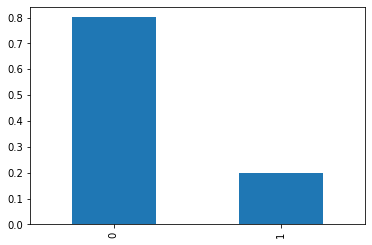

In [35]:
class_frequency = target_train.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

<span style="color:purple">Как можно увидеть, наблюдается явный дисбаланс классов ("0" превосходит "1" практически в 4 раза).<span>

## 2.2. Исследование моделей<a class="anchor" id="2.2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

### 2.2.1. Дерево решений<a class="anchor" id="2.2.1-bullet"></a>

In [36]:
print("F1-мера для дерева решений:")
print()
for md in range(1, 11, 1):
    model_tree = DecisionTreeClassifier(max_depth=md, random_state=100500)
    model_tree.fit(features_train, target_train)
    train_predictions = model_tree.predict(features_train)
    valid_predictions = model_tree.predict(features_valid)
    print("max_depth=", md)
    print("Обучающая выборка:", f1_score(target_train, train_predictions))
    print("Валидационная выборка:", f1_score(target_valid, valid_predictions))
    print("(AUC-ROC для валидационной выборки):", roc_auc_score(target_valid, valid_predictions))
    print()

F1-мера для дерева решений:

max_depth= 1
Обучающая выборка: 0.0
Валидационная выборка: 0.0
(AUC-ROC для валидационной выборки): 0.5

max_depth= 2
Обучающая выборка: 0.5210166177908113
Валидационная выборка: 0.4906204906204907
(AUC-ROC для валидационной выборки): 0.6703561976697858

max_depth= 3
Обучающая выборка: 0.5445689235265465
Валидационная выборка: 0.5128939828080228
(AUC-ROC для валидационной выборки): 0.682410988454972

max_depth= 4
Обучающая выборка: 0.5300546448087432
Валидационная выборка: 0.49117174959871585
(AUC-ROC для валидационной выборки): 0.666712871017147

max_depth= 5
Обучающая выборка: 0.5965087281795511
Валидационная выборка: 0.5627705627705628
(AUC-ROC для валидационной выборки): 0.7082286160963838

max_depth= 6
Обучающая выборка: 0.5924748277689454
Валидационная выборка: 0.5385779122541604
(AUC-ROC для валидационной выборки): 0.6925827625959877

max_depth= 7
Обучающая выборка: 0.6265306122448979
Валидационная выборка: 0.5170876671619613
(AUC-ROC для валидационн

<span style="color:purple">Наиболее адекватной видится модель с max_depth = 5. Здесь f1 на валидационной выборке равна 0.563. Однако до требуемого значения f1 >= 0.59 пока далеко.<span>

### 2.2.2. Случайный лес<a class="anchor" id="2.2.2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [37]:
print("F1-мера для случайного леса:")
print()
for estim in range(10, 101, 10):
    model_forest = RandomForestClassifier(n_estimators=estim, max_depth=12, random_state=100500)
    model_forest.fit(features_train, target_train)
    train_predictions = model_forest.predict(features_train)
    valid_predictions = model_forest.predict(features_valid)
    print("n_estimators=", estim)
    print("Обучающая выборка:", f1_score(target_train, train_predictions))
    print("Валидационная выборка:", f1_score(target_valid, valid_predictions))
    print("(AUC-ROC для валидационной выборки):", roc_auc_score(target_valid, valid_predictions))
    print()

F1-мера для случайного леса:

n_estimators= 10
Обучающая выборка: 0.8217203267659778
Валидационная выборка: 0.5543964232488823
(AUC-ROC для валидационной выборки): 0.7015433767957207

n_estimators= 20
Обучающая выборка: 0.8267564966313764
Валидационная выборка: 0.5580693815987934
(AUC-ROC для валидационной выборки): 0.7025553278160794

n_estimators= 30
Обучающая выборка: 0.8318924111431316
Валидационная выборка: 0.5623100303951368
(AUC-ROC для валидационной выборки): 0.7041346076644686

n_estimators= 40
Обучающая выборка: 0.8376560999039385
Валидационная выборка: 0.5692541856925418
(AUC-ROC для валидационной выборки): 0.7074802571082742

n_estimators= 50
Обучающая выборка: 0.8370086289549377
Валидационная выборка: 0.5714285714285714
(AUC-ROC для валидационной выборки): 0.7086792978756603

n_estimators= 60
Обучающая выборка: 0.8351753964440173
Валидационная выборка: 0.5731707317073171
(AUC-ROC для валидационной выборки): 0.7093110098150159

n_estimators= 70
Обучающая выборка: 0.83923444

<span style="color:purple">Неплохие показатели даёт модель с max_depth=12 и n_estimators= 80. Здесь f1 на валидационной выборке равна 0.578. Только этого мало.<span>

### 2.2.3. Логистическая регрессия<a class="anchor" id="2.2.3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [38]:
print("F1-мера для логистической регрессии:")
print()
model_logreg = LogisticRegression(random_state=100500, solver='liblinear')
model_logreg.fit(features_train, target_train)
train_predictions = model_logreg.predict(features_train)
valid_predictions = model_logreg.predict(features_valid)    
print("Обучающая выборка:", f1_score(target_train, train_predictions))
print("Валидационная выборка:", f1_score(target_valid, valid_predictions))
print("(AUC-ROC для валидационной выборки):", roc_auc_score(target_valid, valid_predictions))
print()

F1-мера для логистической регрессии:

Обучающая выборка: 0.12756909992912827
Валидационная выборка: 0.09623430962343095
(AUC-ROC для валидационной выборки): 0.5155754108021227



<span style="color:purple">Здесь всё совсем грустно.<span>

<span style="color:purple">Таким образом, на несбалансированных данных нам не удалось достичь требуемого значения f1. Попробуем побороться с дисбалансом.<span>

# 3. Борьба с дисбалансом<a class="anchor" id="3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

## 3.1. Увеличение выборки<a class="anchor" id="3.1-bullet"></a>

<span style="color:purple">Применим технику upsampling.<span>

In [39]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=100500)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

<span style="color:purple">Проверим баланс классов.<span>

0    0.501043
1    0.498957
Name: Exited, dtype: float64


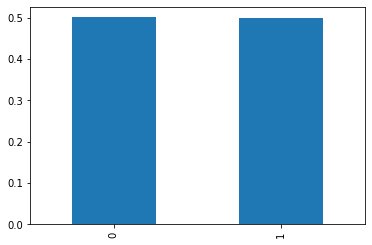

In [40]:
class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

<span style="color:purple">Классы сбалансированы.<span>

<span style="color:purple">Обучим модели на новых данных и посмотрим, что получилось.<span>

### 3.1.1. Дерево решений<a class="anchor" id="3.1.1-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [41]:
print("F1-мера для дерева решений:")
print()
model_tree = DecisionTreeClassifier(max_depth=6, random_state=100500)
model_tree.fit(features_upsampled, target_upsampled)
train_predictions = model_tree.predict(features_upsampled)
valid_predictions = model_tree.predict(features_valid)
print("Обучающая выборка:", f1_score(target_upsampled, train_predictions))
print("Валидационная выборка:", f1_score(target_valid, valid_predictions))
print("(AUC-ROC для валидационной выборки):", roc_auc_score(target_valid, valid_predictions))

F1-мера для дерева решений:

Обучающая выборка: 0.802645174622856
Валидационная выборка: 0.5522935779816515
(AUC-ROC для валидационной выборки): 0.7434128502630618


<span style="color:purple">Как видим, выравнивание классов не улучшило f1 для дерева решений. Однако значение AUC-ROC выросло. <span>

### 3.1.2. Случайный лес<a class="anchor" id="3.1.2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [42]:
print("F1-мера для случайного леса:")
print()
model_forest = RandomForestClassifier(n_estimators=80, max_depth=12, random_state=100500)
model_forest.fit(features_upsampled, target_upsampled)
train_predictions = model_forest.predict(features_upsampled)
valid_predictions = model_forest.predict(features_valid)
print("Обучающая выборка:", f1_score(target_upsampled, train_predictions))
print("Валидационная выборка:", f1_score(target_valid, valid_predictions))
print("(AUC-ROC для валидационной выборки):", roc_auc_score(target_valid, valid_predictions))

F1-мера для случайного леса:

Обучающая выборка: 0.9724940764396827
Валидационная выборка: 0.592074592074592
(AUC-ROC для валидационной выборки): 0.7454912885863135


<span style="color:purple">А вот для случайного леса улучшение f1 заметно - на валидационной выборке мы уже превзошли психологически важную отметку 0.59. AUC-ROC тоже улучшилась.<span>

### 3.1.3. Логистическая регрессия<a class="anchor" id="3.1.3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [43]:
print("F1-мера для логистической регрессии:")
print()
model_logreg = LogisticRegression(random_state=100500, solver='liblinear')
model_logreg.fit(features_upsampled, target_upsampled)
train_predictions = model_logreg.predict(features_upsampled)
valid_predictions = model_logreg.predict(features_valid)    
print("Обучающая выборка:", f1_score(target_upsampled, train_predictions))
print("Валидационная выборка:", f1_score(target_valid, valid_predictions))
print("(AUC-ROC для валидационной выборки):", roc_auc_score(target_valid, valid_predictions))

F1-мера для логистической регрессии:

Обучающая выборка: 0.6758218893050354
Валидационная выборка: 0.446078431372549
(AUC-ROC для валидационной выборки): 0.6586710416884433


<span style="color:purple">Лучше всего польза борьбы с дисбалансом видна для логистической регрессии - значение f1 для валидационной выборки взлетело с 0.10 для несбалансированной выборки до 0.45 для сбалансированной. Увеличение AUC-ROC также заметно.<span>

## 3.2. Уменьшение выборки<a class="anchor" id="3.2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Применим технику downsampling.<span>

In [44]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=100500)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=100500)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=100500)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

<span style="color:purple">Проверим баланс классов.<span>

0    0.501043
1    0.498957
Name: Exited, dtype: float64


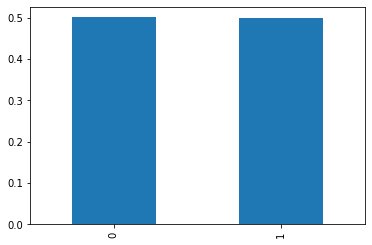

In [45]:
class_frequency = target_downsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

<span style="color:purple">Классы сбалансированы.<span>

<span style="color:purple">Обучим модели на новых данных и посмотрим, что получилось.<span>

### 3.2.1. Дерево решений<a class="anchor" id="3.2.1-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [46]:
print("F1-мера для дерева решений:")
print()
model_tree = DecisionTreeClassifier(max_depth=6, random_state=100500)
model_tree.fit(features_downsampled, target_downsampled)
train_predictions = model_tree.predict(features_downsampled)
valid_predictions = model_tree.predict(features_valid)
print("Обучающая выборка:", f1_score(target_downsampled, train_predictions))
print("Валидационная выборка:", f1_score(target_valid, valid_predictions))
print("(AUC-ROC для валидационной выборки):", roc_auc_score(target_valid, valid_predictions))

F1-мера для дерева решений:

Обучающая выборка: 0.8031892572387748
Валидационная выборка: 0.5597082953509571
(AUC-ROC для валидационной выборки): 0.7502912388977004


<span style="color:purple">И в случае уменьшения выборки выравнивание классов не улучшило f1 для нашего дерева решений. Однако значение AUC-ROC выросло, причём оно ещё выше, чем в случае upsampling.<span>

### 3.2.2. Случайный лес<a class="anchor" id="3.2.2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [47]:
print("F1-мера для случайного леса:")
print()
model_forest = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=100500)
model_forest.fit(features_downsampled, target_downsampled)
train_predictions = model_forest.predict(features_downsampled)
valid_predictions = model_forest.predict(features_valid)
print("Обучающая выборка:", f1_score(target_downsampled, train_predictions))
print("Валидационная выборка:", f1_score(target_valid, valid_predictions))
print("(AUC-ROC для валидационной выборки):", roc_auc_score(target_valid, valid_predictions))

F1-мера для случайного леса:

Обучающая выборка: 0.8749999999999999
Валидационная выборка: 0.5916824196597353
(AUC-ROC для валидационной выборки): 0.7716990021375193


<span style="color:purple">Для случайного леса с параметрами  max_depth=8 и n_estimators= 100 на валидационной выборке удалось достичь значения f1, равного 0.592. AUC-ROC, равная 0.772, также очень хороша.<span>

### 3.2.3. Логистическая регрессия<a class="anchor" id="3.2.3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [48]:
print("F1-мера для логистической регрессии:")
print()
model_logreg = LogisticRegression(random_state=100500, solver='liblinear')
model_logreg.fit(features_downsampled, target_downsampled)
train_predictions = model_logreg.predict(features_downsampled)
valid_predictions = model_logreg.predict(features_valid)    
print("Обучающая выборка:", f1_score(target_downsampled, train_predictions))
print("Валидационная выборка:", f1_score(target_valid, valid_predictions))
print("(AUC-ROC для валидационной выборки):", roc_auc_score(target_valid, valid_predictions))

F1-мера для логистической регрессии:

Обучающая выборка: 0.6750208855472013
Валидационная выборка: 0.4495488105004101
(AUC-ROC для валидационной выборки): 0.6617652182738963


<span style="color:purple">Так же, как и при увеличении выборки, при уменьшении выборки значение f1 в случае логистической регрессии резко возрастает - с 0.10 для несбалансированной выборки до 0.45 для сбалансированной. И увеличение AUC-ROC также хорошо видно.<span>

<span style="color:purple">По результатам исследований лучший результат показала модель случайного леса с применением техники upsampling и параметрами n_estimators=80 и max_depth=12.Проведём проверку этой модели на тестовой выборке.<span>

# 4. Тестирование модели<a class="anchor" id="4-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [49]:
print("F1-мера")
model_optimal = RandomForestClassifier(n_estimators=80, max_depth=12, random_state=100500)
model_optimal.fit(features_upsampled, target_upsampled)
test_predictions = model_optimal.predict(features_test)
print("Тестовая выборка:", f1_score(target_test, test_predictions))

F1-мера
Тестовая выборка: 0.6220204313280364


<span style="color:purple">На тестовой выборке получено значение f1, равное 0.622. Таким образом, удалось достичь f1-меры не менее 0.59.<span>

<span style="color:purple">И в заключение посмотрим, чему равна мера AUC-ROC.<span>

In [50]:
print("AUC-ROC:", roc_auc_score(target_test, test_predictions))

AUC-ROC: 0.7650548319126521


<span style="color:purple">AUC-ROC = 0.765, и это чуть выше, чем на валидационной выборке.<span>